In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
import warnings
import sys, os

warnings.filterwarnings('ignore')
random_state = 6
np.random.seed(random_state)

In [2]:
dir_path = '../../pipeline_modules/'
sys.path.append(dir_path)

In [6]:
import visuals as vs
# filename1 = 'seismogram_data_62.csv'
filename = 'seismogram_data_62_new.csv'
# df_old = pd.read_csv(filename1)
df = pd.read_csv(filename)

### Preprocessing the data

In [7]:
Y = df['target']
X = df.drop(['target'], axis=1)
# x_new_old = df_old.drop(['target'], axis=1)

print(np.shape(X), np.shape(Y))

X, Y = shuffle(X, Y, random_state = random_state)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state=random_state)
mms = StandardScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.fit_transform(X_test)

# X_test = mms.fit_transform(x_new_old)
# Y_test = df_old['target']

(23496, 61) (23496,)


# Support Vector machine

In machine learning, support vector machines (SVMs, also support vector networks) are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. Given a set of training examples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new examples to one category or the other, making it a non-probabilistic binary linear classifier (although methods such as Platt scaling exist to use SVM in a probabilistic classification setting). An SVM model is a representation of the examples as points in space, mapped so that the examples of the separate categories are divided by a clear gap that is as wide as possible. New examples are then mapped into that same space and predicted to belong to a category based on which side of the gap they fall.

## Find best parameter using GridSearchCV

Exhaustive search over specified parameter values for an estimator. GridSearchCV implements a “fit” and a “score” method. It also implements “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used. The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

In [117]:
from sklearn import svm
class_weight={0: 1, 1: 2}
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = random_state)
svm_clss = svm.SVC(class_weight = class_weight, random_state = random_state) 

svm_params = {
    'C': [100, 200, 250, 300, 350, 400, 1000], 
    'gamma': [0.001, 0.008, 0.0003566, 0.0005, 0.01], 
    'kernel': ['rbf']
}

grid_clf = GridSearchCV(estimator = svm_clss, param_grid = svm_params, scoring = 'accuracy', cv = cv, n_jobs=-1)

In [107]:
grid_clf.fit(X_train, Y_train.astype(int))

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=6, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight={0: 1, 1: 2}, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=6, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': [100, 200, 250, 300, 350, 400, 1000], 'gamma': [0.001, 0.008, 0.0003566, 0.0005, 0.01], 'kernel': ['rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [108]:
print(grid_clf.best_params_)
print(grid_clf.best_score_)
print(grid_clf.best_estimator_)

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
0.794268167861
SVC(C=100, cache_size=200, class_weight={0: 1, 1: 2}, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=6, shrinking=True,
  tol=0.001, verbose=False)


## Use best parameters to make final model 

In [8]:
from sklearn import svm

svm_model = svm.SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=6, shrinking=True,
  tol=0.001, verbose=False)

svm_model.fit(X_train, Y_train)
Y_pred = svm_model.predict(X_test)

print('1. The accuracy of the model is {}\n'.format(accuracy_score(Y_test, Y_pred)))
print('2. Classification report \n {} \n'.format(classification_report(Y_test, Y_pred)))
print('3. Confusion matrix \n {} \n'.format(confusion_matrix(Y_pred, Y_test)))
print('4. Roc_Auc score \n {}'.format(roc_auc_score(Y_pred, Y_test)))

1. The accuracy of the model is 0.804468085106383

2. Classification report 
              precision    recall  f1-score   support

        0.0       0.82      0.83      0.82      2567
        1.0       0.79      0.78      0.78      2133

avg / total       0.80      0.80      0.80      4700
 

3. Confusion matrix 
 [[2125  477]
 [ 442 1656]] 

4. Roc_Auc score 
 0.8030013211220525


## Learning curve to check if more data is required to improve performance

In this step of the project, I will check the learning curve of the support vector machine. A learning curve shows the validation and training score of an estimator for varying numbers of training samples. It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error. If both the validation score and the training score converge to a value that is too low with increasing size of the training set, we will not benefit much from more training data. If the training score is much higher than the validation score for the maximum number of training samples, adding more training samples will most likely increase generalization. In the following plot of SVM estimator, we see that the model could benefit from more training examples. We have to add training data to get improved performance.

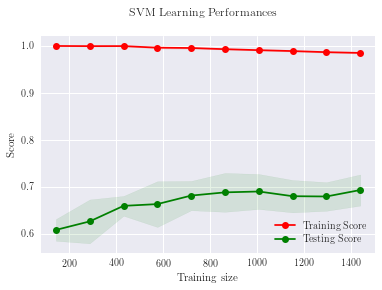

In [136]:
%reload_ext autoreload
%autoreload 2
import visuals as vs
vz = vs.vizualization(df)
vz.check_model_learning(X_train, Y_train, svm_model)

## Bagging of SVM

In this bagging classification ithe above SVM model is the meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator, by introducing randomization into its construction procedure and then making an ensemble out of it.

In [130]:
from sklearn.ensemble import BaggingClassifier
bagging_svm = BaggingClassifier(svm_model, max_samples=0.4, n_estimators=100, n_jobs=-1)
bagging_svm.fit(X_train, Y_train.astype(int))

BaggingClassifier(base_estimator=SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=6, shrinking=True,
  tol=0.001, verbose=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.4, n_estimators=100, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [131]:
Y_pred = bagging_svm.predict(X_test)

print('1. The accuracy of the model is {}\n'.format(accuracy_score(Y_test, Y_pred)))
print('2. Classification report \n {} \n'.format(classification_report(Y_test, Y_pred)))
print('3. Confusion matrix \n {} \n'.format(confusion_matrix(Y_pred, Y_test)))
print('4. Roc_Auc score \n {}'.format(roc_auc_score(Y_pred, Y_test)))

1. The accuracy of the model is 0.7919148936170213

2. Classification report 
              precision    recall  f1-score   support

        0.0       0.82      0.80      0.81      2629
        1.0       0.76      0.78      0.77      2071

avg / total       0.79      0.79      0.79      4700
 

3. Confusion matrix 
 [[2106  455]
 [ 523 1616]] 

4. Roc_Auc score 
 0.7889141232560403
